<a href="https://colab.research.google.com/github/Rob174/Astronomy/blob/Astronomy/AI/Mod%C3%A8le000001.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fonctions de base

In [0]:

##Python / Colab
from google.colab import files
from google.colab import drive
import os
from IPython.display import Image as imgIPython
from IPython.display import clear_output,display
## Tensorflow keras
import tensorflow as tf
from tensorflow.keras import backend as K

from tensorflow.python import debug as tf_debug
from tensorflow.python.client import device_lib

from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense,Conv2D,Convolution2D,Activation,Conv2DTranspose
from tensorflow.keras.layers import MaxPooling2D,AveragePooling2D
from tensorflow.keras.layers import Dropout,Reshape,BatchNormalization
from tensorflow.keras.layers import concatenate,Concatenate,Subtract,Multiply,Average,Add
from tensorflow.keras.layers import UpSampling2D, Reshape,Flatten
from tensorflow.keras.layers import Lambda

from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras import models
from tensorflow.keras.models import Model
import tensorflow.keras.losses

## Math libraries
import numpy as np
import scipy
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
##Images
from PIL import Image
import cv2
## Graph
from graphviz import render
from graphviz import Digraph,Graph

In [2]:
drive.mount('/content/drive')
%cd '/content/drive/My Drive/TIPE'
print("Utilise le",str(device_lib.list_local_devices()[0])[15:18])

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive
/content/drive/My Drive/TIPE
Utilise le CPU


# Setup input

In [0]:
def create_datasets(train_rate=0.7,validation_rate=0.2,test_rate=0.1):
    images = ["Galaxies_resized/"+f for f in os.listdir("Galaxies_resized/")]
    indexes = np.arange(len(images))
    np.random.shuffle(indexes)
    if os.path.exists("Datasets_list.txt"):
        with open("Datasets_list.txt","r") as file:
            train_dataset = file.readline().strip().split(",")
            validation_dataset = file.readline().strip().split(",")
            test_dataset = file.readline().strip().split(",")
    else:
        train_dataset = [images[i] for i in indexes[:int(train_rate*len(images))+1]]
        validation_dataset = [images[i] for i in indexes[int(train_rate*len(images))+1:int((train_rate+validation_rate)*len(images))+1]]
        test_dataset = [images[i] for i in indexes[int((train_rate+validation_rate)*len(images))+1:]]
        with open("Datasets_list.txt","w") as file:
            file.write(",".join(train_dataset))
            file.write(",".join(validation_dataset))
            file.write(",".join(test_dataset))
    return train_dataset,validation_dataset,test_dataset

In [0]:
def next_batch(batch_size, images,tailleAttendue,formatArray):#ATTENTION : pr tenter d'améliorer l'apprentissage, on augmente la taille minimale d'image prise
    """
    formatArray : format de sortie des données de l'image ; utiliser numpy
    """
    imageEntreeTensor = []
    imageSortieTensor = []
    while len(imageEntreeTensor) < batch_size:
        try:
            np.random.shuffle(images)#choix aléatoire de l'image
            image = cv2.imread(images[0])#Ouvre en rgb l'image nettoyée
            resizedImage = cv2.resize(image,(tailleAttendue,tailleAttendue))
            imageSortieTensor.append(np.array(resizedImage,dtype=formatArray))
            imageEntreeTensor.append(np.array(resizedImage,dtype=formatArray))
        except:
            print("Error in next_batch")
    imageEntreeTensor = np.array(imageEntreeTensor,formatArray)
    return [imageEntreeTensor,imageEntreeTensor]

In [0]:
def next_batch_bruit_voile(batch_size, images,tailleAttendue,formatArray,facteursVoile,bruitParam,plageVal=[0,255]):#ATTENTION : pr tenter d'améliorer l'apprentissage, on augmente la taille minimale d'image prise
    """
    formatArray : format de sortie des données de l'image ; utiliser numpy
    facteurVoile : liste de valeur entre 0 et 1 contenant l'atténuation pour chaque couche de l'image
    bruitParam : liste avec dans l'ordre moyenne et écart type
    """
    assert plageVal[0] <= plageVal[1]
    assert plageVal[0] <= bruitParam[0] <= plageVal[1]
    assert plageVal[0] <= bruitParam[0]-bruitParam[1] <= plageVal[1]
    assert plageVal[0] <= bruitParam[0]+bruitParam[1] <= plageVal[1]
    assert formatArray == np.float32
    
    imageEntreeTensor,imageSortieTensor = next_batch(batch_size,  images,tailleAttendue,formatArray)
    imageEntreeTensor,imageSortieTensor = imageEntreeTensor/255,imageSortieTensor/255
    imageSortieTensorCopy = np.array(imageSortieTensor,dtype=np.float32)
    for image in range(imageSortieTensorCopy.shape[0]):
        for rgbIndex in range(3):
            imageSortieTensorCopy[image,:,:,rgbIndex] *= facteursVoile[rgbIndex]
    imageSortieTensorCopy = np.clip(imageSortieTensorCopy + np.random.normal(bruitParam[0],bruitParam[1],imageSortieTensorCopy.shape),plageVal[0],plageVal[1])
    return [imageEntreeTensor,np.array(imageSortieTensorCopy,dtype=formatArray)]

In [0]:
def next_batch_bruit_voile_2(batch_size, images,tailleAttendue,formatArray,facteursVoile,bruitParam,plageVal=[0,255]):#ATTENTION : pr tenter d'améliorer l'apprentissage, on augmente la taille minimale d'image prise
    """
    La versison 2 fait les  modification sélectives de couleurs après avoir ajouté le bruit
    formatArray : format de sortie des données de l'image ; utiliser numpy
    facteurVoile : liste de valeur entre 0 et 1 contenant l'atténuation pour chaque couche de l'image
                   OU liste de liste specifiant la plage de valeurs aléatoire entre lesquelles prendre l'atténuation
    bruitParam : liste avec dans l'ordre moyenne et écart type
    """
    assert plageVal[0] <= plageVal[1]
    assert plageVal[0] <= bruitParam[0] <= plageVal[1]
    assert plageVal[0] <= bruitParam[0]-bruitParam[1] <= plageVal[1]
    assert plageVal[0] <= bruitParam[0]+bruitParam[1] <= plageVal[1]
    assert formatArray == np.float32
    assert type(facteursVoile) == list, "Data type required : list not %s"%(type(facteursVoile))
    assert len(facteursVoile) == 3, "Not the correct amount of data : expected 3 'data' (list or floats) in a list not %d"%(len(facteursVoile))
    facteursVoileImg = []
    if type(facteursVoile[0]) == list:
        if len(facteursVoile[0]) != 2 or len(facteursVoile[1]) != 2 or len(facteursVoile[2]) != 2:
            print("facteursVoile currently used : ",facteursVoile)
            raise ValueError("Expected each facteursVoile subelement to be 3 lists of 2 elements")
        for rgbIndex in range(3):
            colorFactor = []
            for imgIndex in range(batch_size):
                random_value = np.random.rand(1)[0]*(facteursVoile[rgbIndex][1]-facteursVoile[rgbIndex][0])+facteursVoile[rgbIndex][0]
                # print("Random voile with offset : %f"%random_value)
                colorFactor += [random_value]
            facteursVoileImg.append(colorFactor)
    imageEntreeTensor,imageSortieTensor = next_batch(batch_size,  images,tailleAttendue,formatArray)
    imageEntreeTensor,imageSortieTensor = imageEntreeTensor/255,imageSortieTensor/255
    imageSortieTensorCopy = np.array(imageSortieTensor,dtype=np.float32)
    imageSortieTensorCopy = np.array(imageSortieTensorCopy,dtype=formatArray)
    for image in range(imageSortieTensorCopy.shape[0]):
        for rgbIndex in range(3):
            imageSortieTensorCopy[image,:,:,rgbIndex] *= facteursVoileImg[rgbIndex][image]
            imageSortieTensorCopy[image,:,:,rgbIndex] += np.random.normal(bruitParam[0],bruitParam[1])
            # print("Max imageSortieTensorCopy : %d et Max imageEntreeTensor : %d pour img d'index %d et de couleur %d"%(np.max(imageSortieTensorCopy),np.max(imageEntreeTensor),image,rgbIndex))
    # print("Max imageSortieTensorCopy : %d et Max imageEntreeTensor : %d"%(np.max(imageSortieTensorCopy),np.max(imageEntreeTensor)))
    imageSortieTensorCopy /= np.max(imageEntreeTensor)
    imageSortieTensorCopy *= plageVal[1]
    imageSortieTensorCopy = np.clip(imageSortieTensorCopy,plageVal[0],plageVal[1])
    imageEntreeTensor /= np.max(imageEntreeTensor)
    imageEntreeTensor *= plageVal[1]
    imageEntreeTensor = np.clip(imageEntreeTensor,plageVal[0],plageVal[1])
    return [imageEntreeTensor,imageSortieTensorCopy]

In [0]:
def normalisation(arrayL,plageEntree=[0,255],plageSortie=[0,1]):
    assert plageEntree != plageSortie
    assert plageEntree[1]>0 and plageSortie[1] > 0
    formatArray = [array.dtype for array in arrayL]
    L = [np.array(array,dtype=np.float) for array in arrayL]
    for i in range(len(L)):
        L[i] = np.array((L[i]-plageEntree[0])/(plageEntree[1]-plageEntree[0])*(plageSortie[1]-plageSortie[0])+plageSortie[0],formatArray[i])
    return L

# Conversions

In [0]:
def LarrayFloatToUint(L):
    return [np.array(array,np.uint) for array in L]

In [0]:
def convertToUintL(L):
    Lresult = []
    print("Entree : ",len(L))
    for i in range(len(L)):
        Lresult.append(np.array(normalisation(L[i],[0,1],[0,255]),dtype=np.uint8))
    print("Sortie : ",len(Lresult))
    return Lresult

In [0]:
def convertToUint(array):
    return np.array(normalisation(array,[0,1],[0,255]),dtype=np.uint8)

In [0]:
# cf https://stackoverflow.com/questions/43784921/how-to-display-custom-images-in-tensorboard-using-keras?noredirect=1#comment85726690_43784921
def make_image(tensor):
    """
    Convert an numpy representation image to Image protobuf.
    Copied from https://github.com/lanpa/tensorboard-pytorch/
    """
    from PIL import Image
    tensor = np.stack((tensor,tensor,tensor),axis=-1)
    height, width, channel = tensor.shape # numpy.ndarray
    image = Image.fromarray(tensor)
    import io
    output = io.BytesIO()
    image.save(output, format='PNG')
    image_string = output.getvalue()
    output.close()
    CHANNEL = 1
    var = tf.Summary.Image(height=height,
                         width=width,
                         colorspace=CHANNEL,
                         encoded_image_string=image_string)
    print("var : ",var)
    return var

In [0]:
def print_shape(x):
    print("Shape : ",x.get_shape().as_list())

In [0]:
def tauxApprentissage(epoch,ampl,tau,lim):
    taux = ampl*10**-((epoch)/tau)
    return taux if taux > lim else lim

In [0]:
def differenceAcceptee(epoch,ampl,tau,lim):
    taux = ampl*10**-((epoch)/tau)
    return taux if taux > lim else lim

In [0]:
def save_img(img_array_normalized,path):
    assert type(img_array_normalized) == np.ndarray, "Pass a numpy array"
    assert len(img_array_normalized.shape) == 4, "Pass a tensor, a batch of images with 4 dimensions"
    assert img_array_normalized.shape[-1] == 3, "Pass a tensor with 3 channels at the end to build rgb images"
    assert np.max(img_array_normalized) <=1, "Max tensor value must be 1 no %f"%np.max(img_array_normalized)
    individual_path = path
    for i in range(img_array_normalized.shape[0]):
        individual_path = path + "_batchIndex_%d"%(i)
        cv2.imwrite(path+'.jpg', np.uint8(img_array_normalized[i,:,:,:]*255))

# Couches

In [0]:
# source : https://stackoverflow.com/questions/46418373/how-to-resize-interpolate-a-tensor-in-keras
def interpolation(h,w,inputTensor):
    def resize_like(inputTensor,h,w):
        return tf.image.resize_nearest_neighbor(inputTensor, [h, w])

    return Lambda(resize_like, arguments={'h':h,'w':w})(inputTensor)

## SELU

In [0]:
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Optimizer


# Ported from https://github.com/LiyuanLucasLiu/RAdam/blob/master/radam.py
class RectifiedAdam(Optimizer):
    """RectifiedAdam optimizer.
    Default parameters follow those provided in the original paper.
    # Arguments
        lr: float >= 0. Learning rate.
        final_lr: float >= 0. Final learning rate.
        beta_1: float, 0 < beta < 1. Generally close to 1.
        beta_2: float, 0 < beta < 1. Generally close to 1.
        gamma: float >= 0. Convergence speed of the bound function.
        epsilon: float >= 0. Fuzz factor. If `None`, defaults to `K.epsilon()`.
        decay: float >= 0. Learning rate decay over each update.
        weight_decay: Weight decay weight.
        amsbound: boolean. Whether to apply the AMSBound variant of this
            algorithm.
    # References
        - [On the Variance of the Adaptive Learning Rate and Beyond]
          (https://arxiv.org/abs/1908.03265)
        - [Adam - A Method for Stochastic Optimization]
          (https://arxiv.org/abs/1412.6980v8)
        - [On the Convergence of Adam and Beyond]
          (https://openreview.net/forum?id=ryQu7f-RZ)
    """

    def __init__(self, lr=0.001, beta_1=0.9, beta_2=0.999,
                 epsilon=None, decay=0., weight_decay=0.0, **kwargs):
        super(RectifiedAdam, self).__init__(**kwargs)

        with K.name_scope(self.__class__.__name__):
            self.iterations = K.variable(0, dtype='int64', name='iterations')
            self.lr = K.variable(lr, name='lr')
            self.beta_1 = K.variable(beta_1, name='beta_1')
            self.beta_2 = K.variable(beta_2, name='beta_2')
            self.decay = K.variable(decay, name='decay')

        if epsilon is None:
            epsilon = K.epsilon()
        self.epsilon = epsilon
        self.initial_decay = decay

        self.weight_decay = float(weight_decay)

    def get_updates(self, loss, params):
        grads = self.get_gradients(loss, params)
        self.updates = [K.update_add(self.iterations, 1)]

        lr = self.lr
        if self.initial_decay > 0:
            lr = lr * (1. / (1. + self.decay * K.cast(self.iterations,
                                                      K.dtype(self.decay))))

        t = K.cast(self.iterations, K.floatx()) + 1

        ms = [K.zeros(K.int_shape(p), dtype=K.dtype(p)) for p in params]
        vs = [K.zeros(K.int_shape(p), dtype=K.dtype(p)) for p in params]
        self.weights = [self.iterations] + ms + vs

        for p, g, m, v in zip(params, grads, ms, vs):
            m_t = (self.beta_1 * m) + (1. - self.beta_1) * g
            v_t = (self.beta_2 * v) + (1. - self.beta_2) * K.square(g)

            beta2_t = self.beta_2 ** t
            N_sma_max = 2 / (1 - self.beta_2) - 1
            N_sma = N_sma_max - 2 * t * beta2_t / (1 - beta2_t)

            # apply weight decay
            if self.weight_decay != 0.:
                p_wd = p - self.weight_decay * lr * p
            else:
                p_wd = None

            if p_wd is None:
                p_ = p
            else:
                p_ = p_wd

            def gt_path():
                step_size = lr * K.sqrt(
                    (1 - beta2_t) * (N_sma - 4) / (N_sma_max - 4) * (N_sma - 2) / N_sma * N_sma_max /
                    (N_sma_max - 2)) / (1 - self.beta_1 ** t)

                denom = K.sqrt(v_t) + self.epsilon
                p_t = p_ - step_size * (m_t / denom)

                return p_t

            def lt_path():
                step_size = lr / (1 - self.beta_1 ** t)
                p_t = p_ - step_size * m_t

                return p_t

            p_t = K.switch(N_sma > 5, gt_path, lt_path)

            self.updates.append(K.update(m, m_t))
            self.updates.append(K.update(v, v_t))
            new_p = p_t

            # Apply constraints.
            if getattr(p, 'constraint', None) is not None:
                new_p = p.constraint(new_p)

            self.updates.append(K.update(p, new_p))
        return self.updates

    def get_config(self):
        config = {'lr': float(K.get_value(self.lr)),
                  'beta_1': float(K.get_value(self.beta_1)),
                  'beta_2': float(K.get_value(self.beta_2)),
                  'decay': float(K.get_value(self.decay)),
                  'epsilon': self.epsilon,
                  'weight_decay': self.weight_decay}
        base_config = super(RectifiedAdam, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [0]:
from tensorflow.keras.layers import Activation
from tensorflow.keras.utils import get_custom_objects
def SELU(x):
    return 1.0507*K.elu(x,alpha=1.67326)

get_custom_objects().update({'custom_activation': Activation(SELU)})

# A mettre pour le modèle : Activation(SELU)

## LRN2D

In [0]:
class LRN2D(Layer):#Normalisation de réponse locale
    """
    This code is adapted from pylearn2.
    License at: https://github.com/lisa-lab/pylearn2/blob/master/LICENSE.txt
    """

    def __init__(self, alpha=1e-4, k=2, beta=0.75, n=5, **kwargs):
        if n % 2 == 0:
            raise NotImplementedError("LRN2D only works with odd n. n provided: " + str(n))
        super(LRN2D, self).__init__(**kwargs)
        self.alpha = alpha
        self.k = k
        self.beta = beta
        self.n = n

    def get_output(self, train):
        X = self.get_input(train)
        b, ch, r, c = K.shape(X)
        half_n = self.n // 2
        input_sqr = K.square(X)
        extra_channels = K.zeros((b, ch + 2 * half_n, r, c))
        input_sqr = K.concatenate([extra_channels[:, :half_n, :, :],
                                   input_sqr,
                                   extra_channels[:, half_n + ch:, :, :]],
                                  axis=1)
        scale = self.k
        for i in range(self.n):
            scale += self.alpha * input_sqr[:, i:i + ch, :, :]
        scale = scale ** self.beta
        return X / scale

    def get_config(self):
        config = {"name": self.__class__.__name__,
                  "alpha": self.alpha,
                  "k": self.k,
                  "beta": self.beta,
                  "n": self.n}
        base_config = super(LRN2D, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

## Layers graph mode implementation

### Graph

#### Global managment

In [0]:
def g_get_current_id():
	global index_couches
	return str(index_couches)
def g_get_past_id(back=1):
	global index_couches
	return str(index_couches-back)
def g_new_id():
	global index_couches
	index_couches += 1
	return str(index_couches)
Llink = []
def g_link(graph,id1,id2):
    global Llink
    if not([id1,id2] in Llink):
        graph.edge(id1,id2)
        Llink += [id1,id2]
    else:
        print("Link already present : %s"%[id1,id2])
index_graph = 0
index_couches = 0
def new_graph(bgcolor='transparent'):
    """Return the graph"""
    global index_graph
    global index_couches
    index_couches = 0
    graph = Digraph(name="cluster_Graph%d"%(index_graph),format='png')
    graph.attr(bgcolor=bgcolor)
    graph.attr(rankdir="LR")
    index_graph += 1
    return graph
def end_graph(graph,name):
    """Create the png file of the graph"""
    graph.render(name)
def begin_cluster(past_couche,name,color):
	orig_graph = past_couche[1]
	past_couche[1] = Digraph(name="cluster_%s"%(name))
	past_couche[1].attr(style='filled', color=color, label=name)
	return orig_graph, past_couche
def end_cluster(last_couche,orig_graph):
	orig_graph.subgraph(last_couche[1])
	last_couche[1] = orig_graph
	return last_couche

#### Layers

In [0]:
def g_conv(graph,prev,noyau, filtres, strides = 1, auto_connect = True, identifier=False):
	label = None
	if identifier == True:
		print("Received identifier")
	if type(noyau) == int:
		label = "{Convolution %s | {Noyau | %d} | {Filtres | %d} | {Strides | %d}}"%(g_get_current_id(),noyau,filtres,strides)
	else:
		label = "{Convolution %s | {Noyau | %dx%d} | {Filtres | %d} | {Strides | %d}}"%(g_get_current_id(),noyau[0],noyau[1],filtres,strides)
	graph.node(g_get_current_id(),shape="record",label=label,color="black",fillcolor="white" if identifier==False else "red",style="filled")
	if auto_connect == True:
		g_link(graph,id1=prev,id2=g_get_current_id())
def g_max_p(graph,prev,noyau, auto_connect = True, identifier=False):
	label = "{MaxPooling | {Noyau | %d}}"%(noyau)
	graph.node(g_get_current_id(),shape="record",label=label,color="black",fillcolor="white" if identifier==False else "red",style="filled")
	if auto_connect == True:
		g_link(graph,id1=prev,id2=g_get_current_id())
def g_deconv(graph,prev,noyau,filtres, auto_connect = True, identifier=False):
    label = "{Déconvolution %s | {Noyau | %d} | {Filtres | %d}}"%(g_get_current_id(),noyau,filtres)
    graph.node(g_get_current_id(),shape="record",label=label,color="black",fillcolor="white" if identifier==False else "red",style="filled")
    if auto_connect == True:
        g_link(graph,id1=prev,id2=g_get_current_id())
def g_dense(graph,prev,filtres, strides = 1, auto_connect = True, identifier=False):
	label = "{Dense | {Filtres | %d} | {Strides | %d}}"%(filtres,strides)
	graph.node(g_get_current_id(),shape="record",label=label,color="black",fillcolor="white" if identifier==False else "red",style="filled")
	if auto_connect == True:
		g_link(graph,id1=prev,id2=g_get_current_id())

def g_dropout(graph,prev,taux, auto_connect = True, identifier=False):
	label = ""
	if type(taux) == float:
		label = "{Dropout %s | {Rate\n(taux désactivation) | %.3f}}"%(g_get_current_id(),taux)
	else:
		label = "{Dropout %s | {Rate\n(taux désactivation) | Adapté}}"%(g_get_current_id())

	graph.node(g_get_current_id(),shape="record",label=label,color="black",fillcolor="white" if identifier==False else "red",style="filled")
	if auto_connect == True:
		g_link(graph,id1=prev,id2=g_get_current_id())
def g_regLoc(graph,prev,noyau = 20, k = 2, alpha= 10**-4,beta = 0.75, auto_connect = True, identifier=False):
	label = "{Regularisation\nRéponse\nLocale\n%s | {Noyau | %d} | {k | %.2f} | {alpha | %.2e} | {beta | %.2e}}"%(g_get_current_id(),noyau,k,alpha,beta)
	if identifier == True:
		print(identifier)
	graph.node(g_get_current_id(),shape="record",label=label,color="black",fillcolor="white" if identifier==False else "red",style="filled")
	if auto_connect == True:
		g_link(graph,id1=prev,id2=g_get_current_id())
def g_activation(graph,prev,type = "SELU", auto_connect = True, identifier=False):
	label = "{Activation %s | {Type | %s}}"%(g_get_current_id(),type)
	graph.node(g_get_current_id(),shape="record",label=label,color="black",fillcolor="white" if identifier==False else "red",style="filled")
	if auto_connect == True:
		g_link(graph,id1=prev,id2=g_get_current_id())
def g_batch_norm(graph,prev, auto_connect = True, identifier=False):
	label = "{Normalisation\nPar\nBatch\n%s}"%(g_get_current_id())
	graph.node(g_get_current_id(),shape="record",label=label,color="black",fillcolor="white" if identifier==False else "red",style="filled")
	if auto_connect == True:
		g_link(graph,id1=prev,id2=g_get_current_id())
def g_flat(graph,prev, auto_connect = True, identifier=False):
	label = "{Flatten}"
	graph.node(g_get_current_id(),shape="record",label=label,color="black",fillcolor="white" if identifier==False else "red",style="filled")
	if auto_connect == True:
		g_link(graph,id1=prev,id2=g_get_current_id())
def g_concat(graph,index, identifier=False):
    graph.node(g_get_current_id(),"Concatenate\n%s"%(g_get_current_id()),fillcolor="white" if identifier==False else "red")
    for id in index:
        graph.edge(id,g_get_current_id())
def g_add(graph,index, identifier=False):
    graph.node(g_get_current_id(),"+",fillcolor="white" if identifier==False else "red")
    for id in index:
        graph.edge(id,g_get_current_id())
def g_subtract(graph,index, identifier=False):
    graph.node(g_get_current_id(),"-",fillcolor="white" if identifier==False else "red")
    for id in index:
        graph.edge(id,g_get_current_id())
def g_proba(graph,prev, auto_connect = True, identifier=False):
	graph.node(g_get_current_id(),"Probabilite",fillcolor="white" if identifier==False else "red")
	if auto_connect == True:
		g_link(graph,id1=prev,id2=g_get_current_id())

### Graph, Keras

In [0]:
def extract_inpt(inpt):
    inpt,graph,index,improvements = inpt[0],inpt[1],inpt[2],inpt[3]
    return inpt,graph,index,improvements

def g_input(graph, improvements, shape,content_name,draw=True):
    global index_couches
    inpt = Input(shape=shape, name="%d_%s"%(index_couches,content_name))
    if draw == True:
        graph.node(str(index_couches),content_name)
    index_couches += 1
    return [inpt,graph,g_get_past_id(),improvements]
def conv(inpt,k,f,s,operation=False, identifier=False,draw=True,always=False,step=None):
    inpt_tmp,graph,index,improvements = extract_inpt(inpt)
    if identifier == True:
        print("Received identifier at conv level")
    global index_couches
    if improvements != None and improvements == 0 and always == False:
        index_couches += 1
        return [inpt_tmp,graph,index,0]
    if always == True:
        improvements += 1
    
    if operation == True:
        raise Exception("Operation option to check !")
    couche = conv_unit(inpt,k,f,s,operation=operation, identifier=identifier,draw=draw,first=True,step=step)
    couche = conv_unit(couche,k,f,s,operation=operation, identifier=identifier,draw=draw,first=False,step=step)
    couche,graph,index,improvements = extract_inpt(couche)
    if improvements != None:
        improvements = max(improvements-1,0)
    return [couche,graph,g_get_past_id(),improvements]
    
    
def conv_unit(inpt,k,f,s,operation=False, identifier=False,draw=True,first=True,step=None):
    inpt,graph,index,improvements = extract_inpt(inpt)
    global index_couches
    couche = None
    if first == True:
        couche = Convolution2D(filters=f,kernel_size=(k,1),activation=None,strides=(s,s),padding='SAME',name="%d%s_conv_k%d_f%d"%(index_couches,"_step%d"%step if step != None else "",k,f),trainable=True)(inpt)
    else:
        couche = Convolution2D(filters=f,kernel_size=(k,1),activation=None,strides=(s,s),padding='SAME',name="%d%s_conv_k%d_f%d"%(index_couches,"_step%d"%step if step != None else "",k,f),trainable=True)(inpt)
    if identifier == True:
        print("Received identifier at conv_unit level")
    if draw == True:
        if operation == False:
            g_conv(graph,prev=index,noyau=(k,1) if first == True else (1,k),filtres=f,strides=s, identifier=identifier)
        else:
            g_conv(graph,prev=index,noyau=k,filtres=f,strides=s,auto_connect=False, identifier=identifier)
    if identifier == True:
        print("Previous index %s current %s"%(index,g_get_current_id()))
    index_couches += 1
    return [couche,graph,g_get_past_id(),improvements]
def dropout(inpt,r,operation=False, identifier=False,draw=True,always=False):
    name = ""
    global index_couches
    if type(r) != float:
        r = K.cast(r[0,0],K.floatx())
        name = '%d_dropout_r_adaptative'%(index_couches)
    else:
        name = '%d_dropout_r%.2f'%(index_couches,r)
    inpt,graph,index,improvements = extract_inpt(inpt)
    if improvements != None and improvements == 0 and always == False:
        index_couches += 1
        return [inpt,graph,index,0]
    if always == True:
        improvements += 1    
    trainable = True if improvements == None or max(improvements-1,0) > 0 else False
    couche = Dropout(name=name,rate=r,trainable=trainable)(inpt)
    if draw == True:
        if operation == False:
            g_dropout(graph,prev=index,taux=r, identifier=identifier)
        else:
            g_dropout(graph,prev=index,taux=r,auto_connect=False, identifier=identifier)
    index_couches += 1
    return [couche,graph,g_get_past_id(),None if improvements == None else max(improvements-1,0)]
def lrn(inpt,n,k,a,b,operation=False, identifier=False,draw=True):
    inpt,graph,index,improvements = extract_inpt(inpt)
    global index_couches
    if improvements != None and improvements == 0:
        index_couches += 1
        return [inpt,graph,index,0]
    couche = LRN2D(name='%d_lrn_n%d_k%d_a%.2e_b%.2f'%(index_couches,n,k,a,b),n=n,k=k,alpha=a,beta=b)(inpt)
    if draw == True:
        if operation == False:
            g_regLoc(graph,prev=index, identifier=identifier)
        else:
            g_regLoc(graph,prev=index,auto_connect=False, identifier=identifier,always=False)
    index_couches += 1
    return [couche,graph,g_get_past_id(),None if improvements == None else max(improvements-1,0)]
def activ(inpt,act_type,operation=False, identifier=False,draw=True,always=False):
    inpt,graph,index,improvements = extract_inpt(inpt)
    
    global index_couches
    if improvements != None and improvements == 0 and always == False:
        index_couches += 1
        return [inpt,graph,index,0]
    if always == True:
        improvements += 1
    assert act_type=="SELU", "other activation functions than SELU are currently not supported"
    couche = Activation(SELU,name='%d_activation_%s'%(index_couches,act_type))(inpt)
    if draw == True:
        if operation == False:
            g_activation(graph,prev=index, identifier=identifier)
        else:
            g_activation(graph,prev=index,auto_connect=False, identifier=identifier)
    index_couches += 1
    return [couche,graph,g_get_past_id(),None if improvements == None else max(improvements-1,0)]
def b_norm(inpt,operation=False, identifier=False,draw=True):
    inpt,graph,index,improvements = extract_inpt(inpt)
    global index_couches
    if improvements != None and improvements == 0:
        index_couches += 1
        return [inpt,graph,index,0]
    trainable = True if improvements == None or max(improvements-1,0) > 0 else False
    couche = BatchNormalization(name='%d_batchnorm'%(index_couches),trainable=trainable)(inpt)
    if draw == True:
        if operation == False:
            g_batch_norm(graph,prev=index, identifier=identifier)
        else:
            g_batch_norm(graph,prev=index,auto_connect=False, identifier=identifier)
    index_couches += 1
    return [couche,graph,g_get_past_id(),None if improvements == None else max(improvements-1,0)]
def dense(inpt,f,operation=False, identifier=False,draw=True):
    global index_couches
    inpt,graph,index,improvements = extract_inpt(inpt)
    if improvements != None and improvements == 0:
        index_couches += 1
        return [inpt,graph,index,0]
    trainable = True if improvements == None or max(improvements-1,0) > 0 else False
    couche = Dense(f,activation=None,name='%d_dense_f%d'%(index_couches,f),trainable=trainable)(inpt)
    if draw == True:
        if operation == False:
            g_dense(graph,prev=index,filtres=f, identifier=identifier)
        else:
            g_dense(graph,prev=index,filtres=f,auto_connect=False, identifier=identifier)
    index_couches += 1
    return [couche,graph,g_get_past_id(),None if improvements == None else max(improvements-1,0)]
def extract_inpt_L(L):
    L_inpt = [L[i][0] for i in range(len(L))]
    graph = L[0][1]
    ids = [inpt[2] for inpt in L]

    return L_inpt,graph,ids,min([L[i][3] for i in range(len(L))])
def concat(L_inpt,operation=False, identifier=False,draw=True):
    L_inpt,graph,index,improvements = extract_inpt_L(L_inpt)
    improvements += 1
    global index_couches
    couche = Concatenate(axis=-1,name='%d_merge'%(index_couches))(L_inpt)
    if draw == True:
        if operation == False:
            g_concat(graph,index, identifier=identifier)
        else:
            g_concat(graph,index, auto_connect=False, identifier=identifier)

    index_couches += 1
    return [couche,graph,g_get_past_id(),None if improvements == None else max(improvements-1,0)]
def subtract(L_inpt,operation=False, identifier=False):
    L_inpt,graph,index,improvements = extract_inpt_L(L_inpt)
    improvements += 1
    global index_couches
    couche = Subtract(name='%d_subtract'%(index_couches))(L_inpt)
    if draw == True:
        if operation == False:
            g_subtract(graph,index, identifier=identifier)
        else:
            g_subtract(graph,index, auto_connect=False, identifier=identifier)

    index_couches += 1
    return [couche,graph,g_get_past_id(),None if improvements == None else max(improvements-1,0)]
def max_p(inpt,k,operation=False, identifier=False,draw=True):
    inpt,graph,index,improvements = extract_inpt(inpt)
    global index_couches
    trainable = True
    couche = MaxPooling2D(name='%d_max_p_k%d'%(index_couches,k),pool_size=k,padding='VALID',trainable=trainable)(inpt)
    if draw == True:
        if operation == False:
            g_max_p(graph,prev=index,noyau=k, identifier=identifier)
        else:
            g_max_p(graph,prev=index,noyau=k,auto_connect=False, identifier=identifier)
    index_couches += 1
    return [couche,graph,g_get_past_id(),improvements]
def deconv(inpt,k,f,strides,tmp=False,operation=False, identifier=False,draw=True):
    inpt,graph,index,improvements = extract_inpt(inpt)
    global index_couches
    trainable = True 
    couche = Conv2DTranspose(filters=f,kernel_size=k, strides=strides,name='%d_deconv_k%d_f%d'%(index_couches,k,f),padding='VALID',trainable=trainable)(inpt)
    if tmp == True:
        print("WARNING : this is a temporary layer, please not forget to destroy it when you find the right kernel parameter and recreate one deconv with tmp at False")
        return [couche,graph,g_get_current_id(),improvements]
        
    if draw == True:
        if operation == False:
            g_deconv(graph,prev=index,noyau=k,filtres=f, identifier=identifier)
        else:
            g_deconv(graph,prev=index,noyau=k,auto_connect=False, identifier=identifier)
    index_couches += 1
    return [couche,graph,g_get_past_id(),improvements]
def add(L_inpt,operation=False, identifier=False,draw=True):
    global index_couches
    L_inpt,graph,index,improvements = extract_inpt_L(L_inpt)
    improvements += 1
    couche = Add(name='%d_add'%(index_couches))(L_inpt) 
    if draw == True:
        if operation == False:
            g_add(graph,index,identifier=identifier)
        else:
            g_add(graph,index,auto_connect=False,identifier=identifier)

    index_couches += 1
    return [couche,graph,g_get_past_id(),None if improvements == None else max(improvements-1,0)]
def flat(inpt,draw=True):
    inpt,graph,index,improvements = extract_inpt(inpt)
    global index_couches
    if improvements != None and improvements == 0:
        index_couches += 1
        return [inpt,graph,g_get_past_id(),0]
    couche = Flatten(name='%d_flatten'%(index_couches))(inpt)
    if draw == True:
        g_flat(graph,prev=index)
    index_couches += 1
    return [couche,graph,g_get_past_id(),None if improvements == None else max(improvements-1,0)]
def proba(inpt,draw=True):
    inpt,graph,index,improvements = extract_inpt(inpt)
    global index_couches
    if improvements != None and improvements == 0:
        index_couches += 1
        return [inpt,graph,g_get_past_id(),0]
    couche = Activation('sigmoid',name='%d_sigmoid_proba'%(index_couches))(inpt)
    if draw == True:
        g_proba(graph,prev=index)
    index_couches += 1
    return [couche,graph,g_get_past_id(),None if improvements == None else max(improvements-1,0)]

In [0]:
def rgb_to_magn_angle(x,draw=True):
    x,graph,index,improvements = x[0],x[1],x[2],x[3]
    x = Lambda(lambda x:K.cast(x,"complex64"))(x)
    x_list_magn = []
    x_list_angle = []
    for i in range(3):
        fft = Lambda(lambda x: tf.fft2d(x[:,:,:,i]), output_shape=(None,199,199))(x)
        x_list_magn.append(Lambda(lambda fft:K.expand_dims(tf.math.abs(fft),axis=-1), output_shape=(None,199,199))(fft))
        x_list_angle.append(Lambda(lambda fft: K.expand_dims(tf.math.angle(fft),axis=-1), output_shape=(None,199,199))(fft))
    magn = Concatenate()(x_list_magn)
    angle = Concatenate()(x_list_angle)
    magn = Lambda(lambda magn: K.cast(magn,dtype=tf.float32), output_shape=(None,199,199))(magn)
    angle = Lambda(lambda angle: K.cast(angle,dtype=tf.float32), output_shape=(None,199,199))(angle)
    if draw == True:
#         print("Draw FFT at index %s"%g_get_current_id())
        graph.node(g_get_current_id(),"FFT")
        g_link(graph,index,g_get_current_id())
    global index_couches
    index_couches += 1
    return [magn,graph,g_get_past_id(),improvements],[angle,graph,g_get_past_id(),improvements]
def to_rgb(magn,angle,magn_train,angle_train,draw=True):
    magn,graph,magn_index,improvements = extract_inpt(magn)
    angle,graph,angle_index,improvements = extract_inpt(angle)
    magn = Lambda(lambda magn: K.cast(magn,dtype=tf.complex64))(magn)
    angle = Lambda(lambda angle:K.cast(angle,dtype=tf.complex64))(angle)
    x_list_canal = []
    for i in range(3):
        complx_tensor = Lambda(lambda mang_angle: mang_angle[0][:,:,:,i]*tf.exp(1j*mang_angle[1][:,:,:,i]))([magn,angle])
        ifft = Lambda(tf.ifft2d)(complx_tensor)
        x_list_canal.append(K.expand_dims(ifft,axis=-1))
    images = Concatenate()(x_list_canal)
    images = K.cast(images,dtype=tf.float32)
    if draw == True:
        graph.node(g_get_current_id(),"RGB")
        if magn_train == True:
            g_link(graph,magn_index,g_get_current_id())
        if angle_train == True:
            g_link(graph,angle_index,g_get_current_id())
    global index_couches
    index_couches += 1
    return [images,graph,g_get_past_id(),improvements]

###Couches composites

In [0]:
def unit(inpt,k,f,dropout_r=None,activation=False,draw=False,init_index=None,identifier=False):
    if identifier == True:
        print("Identifier : ",identifier)
    if init_index != None:
        global index_couches
        index_couches = init_index
    couche = conv(inpt,k=k,f=f,s=1,draw=draw,identifier=identifier)
    couche = b_norm(couche,draw=draw,identifier=identifier)
    couche = lrn(couche,n=21,k=2,a=10**-4,b=0.75,draw=draw,identifier=identifier)
    if activation == True:
        couche = activ(couche,act_type="SELU",draw=draw,identifier=identifier)
    if dropout_r != None:
        couche = dropout(couche,r=dropout_r,draw=draw,identifier=identifier)
    return couche

In [0]:
def compare_shape(t1,t2):
    if len(t1) != len(t2):
        return False
    for elem1,elem2 in zip(t1,t2):
        if elem1 != elem2:
            return False
    return True

In [0]:
#Because we need to have both the former layer and the layer resulting of the next floor we have to split the "etage" in an down function and an up function that will create respectively the left and the right part 
def etage_down(inpt_before,pool_k,k,f,dropout_r=None,activation=False,draw=False,init_index=None):
    """We consider that a treatment has been already done on the inpt_before layer ;
    on the other side the etage function will restitute a layer with dimensions that match with inpt_before ;
    if we are at the last etage we will only call one / multiple units with the two ouputs layers
    In order to keep mostly the same weights we will always keep max pool and deconv layers in the process with deconv non trainable --> in the corresponding layers"""
    reduced = max_p(inpt_before,pool_k,draw=draw)
    after_process = unit(reduced,k,f,dropout_r=dropout_r,activation=True,draw=draw,init_index=init_index)
    return after_process

def etage_up(inpt_before,inpt_after,after_process,k,f,dropout_r=None,activation=False,draw=False,init_index=None):
    _,_,_,improvements_size_modif = extract_inpt(inpt_before)
    _,_,_,improvements_processing = extract_inpt(after_process)
    
    inpt_after[3] = improvements_processing
    after_process[3] = improvements_processing
    inpt_after = concat([inpt_after,after_process],operation=False, identifier=False,draw=draw)
    inpt_after_processed = unit(inpt_after,k,f,dropout_r=dropout_r,activation=activation,draw=draw,init_index=init_index)
    
    output = deconv(inpt_after_processed,k=2,f=inpt_before[0].get_shape().as_list()[-1],strides=(2,2),
                    tmp=False,draw=draw)
    if compare_shape(output[0].get_shape().as_list(),inpt_before[0].get_shape().as_list()) != True:
        raise Exception("No appropriate deconvolution kernel found with desired shape %s\nand input of deconvolution %s"%(inpt_before[0].get_shape().as_list(),output[0].get_shape().as_list()))
    return output

# Model

## Global model

In [0]:
def inception(inpt,draw=True):
    orig_graph, inpt = begin_cluster(past_couche=inpt,name="Inception%s"%(g_get_current_id()),color='red')
    
    T0 = unit(inpt,k=1,f=100,activation=True,dropout_r=0.5,draw=draw)
    T1 = unit(inpt,k=1,f=100,activation=True,dropout_r=0.5,draw=draw)
    T1 = unit(T1,k=1,f=100,activation=True,dropout_r=0.5,draw=draw)

    couche = concat([T0,T1],draw=draw)
    couche = conv(couche,k=1,f=100,s=1,draw=draw)
    couche = add([couche,inpt],draw=draw)
    end_cluster(last_couche=couche, orig_graph=orig_graph)
    return couche

In [0]:
def sauvegardeModele(entree_pure,entree_deterioree,model,iteration_entrainement,summary_writer,batch_size=5):
    global Llayers
    for canal_image in range(3):
        summary_image = tf.Summary(value=[tf.Summary.Value(tag="input_pure_canal_"+str(canal_image), 
                                image=make_image(np.array(entree_pure[0][0,:,:,canal_image]*255,dtype=np.uint8)))])
        summary_writer.add_summary(summary_image,iteration_entrainement)
        summary_image = tf.Summary(value=[tf.Summary.Value(tag="input_deterioree_canal_"+str(canal_image), 
                                image=make_image(np.array(entree_deterioree[0][0,:,:,canal_image]*255,dtype=np.uint8)))])
        summary_writer.add_summary(summary_image,iteration_entrainement)
        
    for p,entree in enumerate([entree_pure,entree_deterioree]):
        print("p value %d"%(p))
        layer_outputs,layer_names = [Llayers[i][0] for i in range(len(Llayers))],[Llayers[i][1] for i in range(len(Llayers))]
        model_calcul_image = Model(inputs=model.input,outputs=[model.output]+layer_outputs)
        sorties_couches = model_calcul_image.predict(entree, batch_size=batch_size)[1:] if len(layer_outputs) > 0 else [model_calcul_image.predict(entree, batch_size=batch_size)][1:]
        
        for index_couche,sortie_couche in enumerate(sorties_couches):
            layer_name = layer_names[index_couche]
            dim_sortie = sortie_couche.shape
            if len(dim_sortie) == 4:
                for canal_image in range(dim_sortie[-1]):
                    tag = layer_name
                    tag += 'pure' if p == 0 else 'deterioree'
                    tag += "_canal_" + str(canal_image)
                    summary_image = tf.Summary(value=[tf.Summary.Value(tag=tag, 
                                            image=make_image(np.array(sortie_couche[0,:,:,canal_image]*255,dtype=np.uint8)))])
                    summary_writer.add_summary(summary_image,iteration_entrainement)
    return None

In [0]:
from google.colab import output
def beep():
    output.eval_js('new Audio("https://upload.wikimedia.org/wikipedia/commons/0/05/Beep-09.ogg").play()')
    return None

In [0]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import time
continuer = None
def block_or_continue():
    beep()
    print("Would you resume training ? True or False ?")
    return bool(input())

In [0]:
def backup(image,imageBruitee,gen_disc,disc,index,summary_writer):
    x = [np.concatenate((image[0],imageBruitee[0])),np.concatenate((image[1],imageBruitee[1]))]
    sauvegardeModele(image,imageBruitee,gen_disc,index,summary_writer)
    p_gen_disc = gen_disc.predict(x)[0]
    p_disc = disc.predict(x)[0]

    summary_loss = tf.Summary(value=[tf.Summary.Value(tag="Probabilité gen-disc img 0 (orig pure) pure : ", 
                                        simple_value=p_gen_disc) ])
    summary_writer.add_summary(summary_loss,index)
    summary_loss = tf.Summary(value=[tf.Summary.Value(tag="Probabilité disc img 0 (orig pure) pure : ", 
                                        simple_value=p_disc) ])
    summary_writer.add_summary(summary_loss,index)
    x_proba = [np.concatenate((imageBruitee[0],imageBruitee[0])),np.concatenate((imageBruitee[1],imageBruitee[1]))]
    p_gen_disc = gen_disc.predict(x_proba)[0]
    p_disc = disc.predict(x_proba)[0]
    summary_loss = tf.Summary(value=[tf.Summary.Value(tag="Probabilité gen-disc img 0 (orig détériorée) pure : ", 
                                        simple_value=p_gen_disc) ])
    summary_writer.add_summary(summary_loss,index)
    summary_loss = tf.Summary(value=[tf.Summary.Value(tag="Probabilité disc img 0 (orig détériorée) pure : ", 
                                        simple_value=p_disc) ])
    summary_writer.add_summary(summary_loss,index)

In [0]:
def custom_loss(y_true,y_pred):
    return K.mean(K.square(y_pred - y_true),axis=-1)+K.max(K.square(y_pred - y_true),axis=-1)

In [0]:
def to_fft(img_tensor):
    L = []
    print(img_tensor.shape[0],img_tensor.get_shape().as_list())
    for index_image in range(img_tensor.get_shape().as_list()[0]):
        L.append(to_fft_single(img_tensor[index_image,:,:,:]))
    return np.stack(L,axis=0)

def to_img(fft_cplx):
    return to_uint8_array(np.fft.ifft2(fft_cplx))
def to_fft_single(img):
    fft_cplx = np.fft.fft2(img)
    fft = 20*np.log(np.abs(fft_cplx)+10**-5*np.ones(img.shape))
    fft = fft + np.abs(np.min(fft))*np.ones(fft.shape)
    fft = fft / (np.max(fft)*np.ones(fft.shape))*(255*np.ones(fft.shape))
    fft_uint8 = to_uint8_array(fft)
    print(np.max(fft_uint8),np.min(fft_uint8),fft_uint8.shape,fft_uint8.dtype)
    return fft_cplx

def to_uint8_array(array):
    return array.astype(np.uint8)
def next_batch_bruit_voile_fft():
    image,imageBruitee = next_batch_bruit_voile_2(10,images,199,np.float32,[1,1,1],[50,50])
    

## FFT Pretraining

### Model

In [0]:
def analyse_progressive_training_model(couche,step=0,init=2,draw=True):
    #input size has to be 2**4=16 min but we wil take 2**8=256
    level0_in = unit(couche,k=2,f=100,activation=True,dropout_r=0.1,init_index=init,draw=draw)#Output size around 256
    down1 = etage_down(level0_in,pool_k=2,k=2,f=100,dropout_r=0.1,activation=True,draw=draw)#Output size around 128
    down2 = etage_down(down1,pool_k=2,k=2,f=100,dropout_r=0.1,activation=True,draw=draw)#Output size around 64
    down3 = etage_down(down2,pool_k=2,k=2,f=100,dropout_r=0.1,activation=True,draw=draw)#Output size around 32
    down4 = etage_down(down3,pool_k=2,k=2,f=100,dropout_r=0.1,activation=True,draw=draw)#Output size around 16
    
    final_analysis = unit(down4,k=2,f=100,activation=True,draw=draw)#Output size around 16
    
    up4 = etage_up(inpt_before=down3,inpt_after=final_analysis,after_process=down4,k=2,f=100,dropout_r=0.1,activation=True,draw=draw)#Output size around 32
    up3 = etage_up(inpt_before=down2,inpt_after=up4,after_process=down3,k=2,f=100,dropout_r=0.1,activation=True,draw=draw)#Output size around 64
    up2 = etage_up(inpt_before=down1,inpt_after=up3,after_process=down2,k=2,f=100,dropout_r=0.1,activation=True,draw=draw)#Output size around 128
    up1 = etage_up(inpt_before=level0_in,inpt_after=up2,after_process=down1,k=2,f=100,dropout_r=0.1,activation=True,draw=draw)#Output size around 256
    level0_out = concat([level0_in,up1],draw=draw)
    level0_out[3] = couche[3]
    level0_out = unit(level0_out,k=2,f=3,activation=True,dropout_r=0.1,draw=draw)#Bonne taille
    return  level0_out


In [0]:
index_couches = -12
def model_fft_training(step,half_batch_size,name,magn_select=True,angle_select=True):#else angle
    global index_disc
    global index_couches
    index_couches = 1
    graph = new_graph()
    inpt = g_input(graph=graph, improvements=step, shape=(256, 256, 3),content_name="Image")
    inpt_real = g_input(graph=graph, improvements=step, shape=(256, 256, 3),content_name="Image_real",draw=False)

    magn,angle = rgb_to_magn_angle(inpt,draw=True)
    r_magn,r_angle = rgb_to_magn_angle(inpt_real,draw=False)

    if magn_select == True:
        magn = analyse_progressive_training_model(magn,step=step,init=3)
    if angle_select == True:
        angle = analyse_progressive_training_model(angle,step=step,init=150)
    img_rgb = to_rgb(magn=magn,angle=angle,magn_train=magn_select,angle_train=angle_select) 
    model = Model(inputs=[inpt[0],inpt_real[0]],outputs=img_rgb[0])
    end_graph(img_rgb[1],name=name)
    return model, r_magn[0],r_angle[0], magn[0], angle[0]

In [0]:
# validation = None
# for step in range(38,100):#21
#     for training_L in [[False,True],[True,False],[True,True]]:
#         base_name = "Pretrain_test_fft_%d"%10
#         graph_name = base_name
#         if training_L[0] == True:
#             graph_name += "_magn"
#         if training_L[1] == True:
#             graph_name += "_angle"
#         graph_name = graph_name + "_%d"%(step)
#         backup_path = graph_name + ".h5"
#         global index_couches
#         model_fft_training(step,half_batch_size=5,name=graph_name,magn_select=training_L[0],angle_select=training_L[1])
#         print("Is it a correct graph for step %d angle %r et magn %r ?"%(step,training_L[0],training_L[1]))
#         print("path : %s"%('%s.png'%(graph_name)))
#         graph = imgIPython(filename='%s.png'%(graph_name)) 
#         display(graph)
#         validation = input()
#         if validation == "e":
#             break
#         if validation != "t":
#             raise Exception("The graph is not correct")
    
#     if validation == "e":
#         break

### Backup

In [0]:
def restore_modified_network(past_model,new_model):
    layers = [layer.name for layer in new_model.layers]
    for layer in past_model.layers:
        if layer.name in layers:
            print("Restoring layer %s"%layer.name)
            try:
                new_model.get_layer(layer.name).set_weights(layer.get_weights())
            except Exception as e:
                print("Can't load weights because ")
                print(str(e))
                print("So, nothing done for the layer %s"%(layer.name))

In [0]:
def search_restore_pt(index_model,model,magn_trained,angle_trained,base_name):
    best_angle_training = None
    best_magn_training = None
    max_step_angle = 0
    max_step_magn = 0
    folder = "Model%d/"%index_model
    if os.path.exists(folder) == False:
        print("No restore point found")
        return None
    for file in os.listdir(folder):
        if file.endswith(".h5") and base_name in file:
            if "magn" in file and int(file.split(".")[0].split("_")[-1]) >= max_step_magn:
                best_magn_training = folder + file
                max_step_magn = int(file.split(".")[0].split("_")[-1])
            if "angle" in file and int(file.split(".")[0].split("_")[-1]) >= max_step_angle:
                best_angle_training = folder + file
                max_step_angle = int(file.split(".")[0].split("_")[-1])
    # Pour cette étape d'entrainement, 
    #       - soit uniquement l'un des deux a été entrainé séparément : cas où à l'iteration step on arrive à magn = True et angle = True 
    #               -> magn déjà entrainé pour step mais angle en est encore à step-1
    #           --> on restaure d'abord le fichier contenant angle et magn de l'étape précédante puis celui d'entrainement particulier
    #           --> soit d'abord dans tous les cas le fichier de angle puis celui de magn
    #       - soit les deux ont été entrainés séparément
    #           --> on restaure les deux fichier sans ordre préférentiel car chaque fichier ne contient pas d'info sur un reseau analysant l'autre partie de l'image
    #       - soit les deux ont été entrainés en commun 
    #           --> on restaure d'abord le fichier contenant angle et magn de l'étape précédante puis celui d'entrainement particulier
    # Dans l'ordre on fait angle1 -> magn1 -> magn_angle1 -> angle2 -> magn2 -> magn_angle2 -> ...
    if (angle_trained == True and magn_trained == False) or (angle_trained == False and magn_trained == True) and (best_angle_training != None and best_magn_training != None):
        # Cas angle2 ou magn2
        print("Restoring weights...")
        model_prec,_,_, _,_ = model_fft_training(step=max_step_magn,#To avoid problems after training angle of this step
                                                                           half_batch_size=5,
                                                                  name=graph_name,magn_select=True,
                                                                  angle_select=True)
        model_prec.load_weights(best_angle_training,by_name=True)
        restore_modified_network(past_model=model_prec,new_model=model)
    elif (angle_trained == True and magn_trained == True) and (best_angle_training != None and best_magn_training != None):
        print("Restoring weights from models angle_magn into magn_angle...")
        # Cas magn_angle1 : on construit angle1 et magn1 et on met les variables dans le nouveau modèle
        model_prec_angle,_,_, _,_ = model_fft_training(step=max_step_magn,half_batch_size=5,
                                                                  name=base_name,magn_select=True,
                                                                  angle_select=True)
        model_prec_magn,_,_, _,_ = model_fft_training(step=max_step_magn,half_batch_size=5,
                                                                  name=base_name,magn_select=True,
                                                                  angle_select=True)
        model_prec_angle.load_weights(best_angle_training,by_name=True)
        restore_modified_network(past_model=model_prec_angle,new_model=model)
        model_prec_magn.load_weights(best_magn_training,by_name=True)
        restore_modified_network(past_model=model_prec_magn,new_model=model)
    else:
        print("%s restore point found for angle and %s restore point found for magn"%("No" if best_angle_training == None else "One","no" if best_magn_training == None else "one"))

In [0]:
def backup_fft(num_model,model,image,imageBruitee,graph_name,step,iteration,metrics_list_names,model_state_backup_int=5):
    if os.path.exists("Model%d"%num_model) == False:
        os.mkdir("Model%d"%num_model)
    folder = "Model%d/"%num_model
    metrics_list_values_clean = model.test_on_batch([image,image],image)
    metrics_list_values_noise = model.test_on_batch([imageBruitee,image],image)
    if len(metrics_list_values_clean) != len(metrics_list_names) and len(metrics_list_values_noise) != len(metrics_list_names):
        raise Exception("Metrics names number and model outputs not matching with %d values for model output and %d values for names"%(len(metrics_list_values_clean),len(metrics_list_names)))
    metrics_names = []
    metrics_list_values = []
    for i,name in enumerate(metrics_list_names):
        metrics_names += [name+"_clean",name+"_noise"]
        metrics_list_values += [metrics_list_values_clean[i],metrics_list_values_noise[i]]
    metrics_names = ["Iteration"] + metrics_names
    metrics_list_values = [iteration] + metrics_list_values
    if iteration % model_state_backup_int == 0:
        model.save_weights(folder + graph_name+".h5")
        save_img(image,folder + graph_name+"_%d_img"%iteration)
        save_img(imageBruitee,folder + graph_name+"_%d_img_bruit"%iteration)
        img_gen = model.predict([image,image])
        img_bruit_gen = model.predict([imageBruitee,image])
        save_img(np.clip(img_gen,0,1),folder + graph_name+"_%d_img_gen"%iteration)
        save_img(np.clip(img_bruit_gen,0,1),folder + graph_name+"_%d_img_bruit_gen"%iteration)

    append_write = "w"
    backup_file_path = folder + graph_name+"_step%d_metrics.txt"%step
    if os.path.exists(backup_file_path):
        append_write = 'a' # append if already exists
    with open(backup_file_path,append_write) as file:
        if os.stat(backup_file_path).st_size == 0:
            file.write(",".join(list(map(lambda x:str(x),metrics_names)))+"\n")
        file.write(",".join(list(map(lambda x:str(x),metrics_list_values)))+"\n")
    print("".join([metrics_names[i] + " : " + str(metrics_list_values[i]) + "; " for i in range(len(metrics_list_values))]))


### Loss & Metrics

In [0]:
def fft_loss(r_magn,r_angle, gen_magn,gen_angle):
    def loss(y_true,y_pred):
        return K.mean(K.square(r_magn - gen_magn), axis=-1) + K.mean(K.square(r_angle - gen_angle), axis=-1)
    return loss

In [41]:
Lmetrics = []
Lnames = []
def generate_functions(name,type_data,input_first_function,expression):
    global Lmetrics
    global Lnames
    Lnames.append("%s"%(expression).replace("y","rgb"))
    Lmetrics.append("metrics_%s_%s(%s)"%(type_data,name,",".join(input_first_function)))
    print("def metrics_%s_%s(%s):\n\tdef %s_%s(y_true,y_pred):\n\t\treturn %s\n\treturn %s_%s"%(type_data,name,",".join(input_first_function),type_data,name,expression,type_data,name))
    print()
for minmax in ["min","max"]:
    for magnangle in ["magn","angle"]:
        generate_functions("%s_%s"%(minmax,magnangle),"fft",["r_%s"%(magnangle)],"K.%s(r_%s)"%(minmax,magnangle))
for magnangle in ["magn","angle"]:
    generate_functions("max_abs_diff_%s"%(magnangle),"fft",["r_%s"%(magnangle),"gen_%s"%(magnangle)],"K.max(K.abs(r_%s-gen_%s))"%(magnangle,magnangle))
for magnangle in ["magn","angle"]:
    generate_functions("mean_abs_diff_%s"%(magnangle),"fft",["r_%s"%(magnangle),"gen_%s"%(magnangle)],"K.mean(K.abs(r_%s-gen_%s))"%(magnangle,magnangle))
for magnangle in ["magn","angle"]:
    generate_functions("var_abs_diff_%s"%(magnangle),"fft",["r_%s"%(magnangle),"gen_%s"%(magnangle)],"K.var(K.abs(r_%s-gen_%s))"%(magnangle,magnangle))
generate_functions("max_abs_diff_%s"%(magnangle),"rgb",[],"K.mean(K.abs(y_true-y_pred))")
print("[%s]"%(",".join(Lmetrics)))
print("[%s]"%(",".join(list(map(lambda x:"'"+x+"'",Lnames)))))

def metrics_fft_min_magn(r_magn):
	def fft_min_magn(y_true,y_pred):
		return K.min(r_magn)
	return fft_min_magn

def metrics_fft_min_angle(r_angle):
	def fft_min_angle(y_true,y_pred):
		return K.min(r_angle)
	return fft_min_angle

def metrics_fft_max_magn(r_magn):
	def fft_max_magn(y_true,y_pred):
		return K.max(r_magn)
	return fft_max_magn

def metrics_fft_max_angle(r_angle):
	def fft_max_angle(y_true,y_pred):
		return K.max(r_angle)
	return fft_max_angle

def metrics_fft_max_abs_diff_magn(r_magn,gen_magn):
	def fft_max_abs_diff_magn(y_true,y_pred):
		return K.max(K.abs(r_magn-gen_magn))
	return fft_max_abs_diff_magn

def metrics_fft_max_abs_diff_angle(r_angle,gen_angle):
	def fft_max_abs_diff_angle(y_true,y_pred):
		return K.max(K.abs(r_angle-gen_angle))
	return fft_max_abs_diff_angle

def metrics_fft_mean_abs_diff_magn(r_magn,gen_magn):
	def fft_mean_abs_diff_magn(y_true,y_pred):
		return K.mean(K.abs(r_magn-gen_magn))
	return fft_mean_abs_diff_magn

def metrics_fft_mean_abs_diff_an

In [0]:
def metrics_fft_min_magn(r_magn):
	def fft_min_magn(y_true,y_pred):
		return K.min(r_magn)
	return fft_min_magn

def metrics_fft_min_angle(r_angle):
	def fft_min_angle(y_true,y_pred):
		return K.min(r_angle)
	return fft_min_angle

def metrics_fft_max_magn(r_magn):
	def fft_max_magn(y_true,y_pred):
		return K.max(r_magn)
	return fft_max_magn

def metrics_fft_max_angle(r_angle):
	def fft_max_angle(y_true,y_pred):
		return K.max(r_angle)
	return fft_max_angle

def metrics_fft_max_abs_diff_magn(r_magn,gen_magn):
	def fft_max_abs_diff_magn(y_true,y_pred):
		return K.max(K.abs(r_magn-gen_magn))
	return fft_max_abs_diff_magn

def metrics_fft_max_abs_diff_angle(r_angle,gen_angle):
	def fft_max_abs_diff_angle(y_true,y_pred):
		return K.max(K.abs(r_angle-gen_angle))
	return fft_max_abs_diff_angle

def metrics_fft_mean_abs_diff_magn(r_magn,gen_magn):
	def fft_mean_abs_diff_magn(y_true,y_pred):
		return K.mean(K.abs(r_magn-gen_magn))
	return fft_mean_abs_diff_magn

def metrics_fft_mean_abs_diff_angle(r_angle,gen_angle):
	def fft_mean_abs_diff_angle(y_true,y_pred):
		return K.mean(K.abs(r_angle-gen_angle))
	return fft_mean_abs_diff_angle

def metrics_fft_var_abs_diff_magn(r_magn,gen_magn):
	def fft_var_abs_diff_magn(y_true,y_pred):
		return K.var(K.abs(r_magn-gen_magn))
	return fft_var_abs_diff_magn

def metrics_fft_var_abs_diff_angle(r_angle,gen_angle):
	def fft_var_abs_diff_angle(y_true,y_pred):
		return K.var(K.abs(r_angle-gen_angle))
	return fft_var_abs_diff_angle

def metrics_rgb_max_abs_diff_angle():
	def rgb_max_abs_diff_angle(y_true,y_pred):
		return K.mean(K.abs(y_true-y_pred))
	return rgb_max_abs_diff_angle

### Training

In [0]:
def train_progressive_model(index_model,max_step=200, max_it=2000):
    train_data,validation_data,test_data = create_datasets()
    max_total_it = (max_step-1)*3*max_it
    tot_iteration = 0
    for step in range(40,max_step):
        magn_choice, angle_choice = True,True
        if magn_choice == False and angle_choice == False:
            continue

        base_name = "Pretrain_fft_%d"%index_model
        graph_name = base_name
        if magn_choice == True:
            graph_name += "_magn"
        if angle_choice == True:
            graph_name += "_angle"
        graph_name = graph_name + "_%d"%(step)
        backup_path = graph_name + ".h5"
        model,r_magn,r_angle, gen_magn,gen_angle = model_fft_training(step=step,half_batch_size=5,
                                                                        name=graph_name,magn_select=magn_choice,angle_select=angle_choice)
        
        metrics_list = [metrics_fft_min_magn(r_magn),metrics_fft_min_angle(r_angle),
                        metrics_fft_max_magn(r_magn),metrics_fft_max_angle(r_angle),
                        metrics_fft_max_abs_diff_magn(r_magn,gen_magn),metrics_fft_max_abs_diff_angle(r_angle,gen_angle),
                        metrics_fft_mean_abs_diff_magn(r_magn,gen_magn),metrics_fft_mean_abs_diff_angle(r_angle,gen_angle),
                        metrics_fft_var_abs_diff_magn(r_magn,gen_magn),metrics_fft_var_abs_diff_angle(r_angle,gen_angle),
                        metrics_rgb_max_abs_diff_angle()]
        metrics_list_names = ["Loss",'K.min(r_magn)','K.min(r_angle)',
                                'K.max(r_magn)','K.max(r_angle)',
                                'K.max(K.abs(r_magn-gen_magn))','K.max(K.abs(r_angle-gen_angle))',
                                'K.mean(K.abs(r_magn-gen_magn))','K.mean(K.abs(r_angle-gen_angle))',
                                'K.var(K.abs(r_magn-gen_magn))','K.var(K.abs(r_angle-gen_angle))',
                                'K.mean(K.abs(rgb_true-rgb_pred))']
        optimizer = Adam(learning_rate=1e-5, beta_1=0.9, beta_2=0.999, amsgrad=False)
        model.compile(loss=fft_loss(r_magn,r_angle, gen_magn,gen_angle),metrics=metrics_list,optimizer="Adam")
        search_restore_pt(index_model,model=model, magn_trained=magn_choice,angle_trained=angle_choice,
                            base_name=graph_name)
        for iteration in range(max_it):
            if step == 40 and iteration < 1406:
                continue
            image,imageBruitee = next_batch_bruit_voile_2(5,train_data,256,np.float32,
                                                            [[0,1.-iteration/(max_it+1)],[0,1.-iteration/(max_it+1)],[0,1.-iteration/(max_it+1)]],
                                                            [iteration//100*100/max_it/2,iteration//100*100/max_it/2],[0,1])
            x = np.concatenate((image,imageBruitee),axis=0)
            y = np.concatenate((image,image),axis=0)
            metrics_list_values = model.train_on_batch([x,y],y)
            loss = metrics_list_values[0]
            backup_fft(index_model,model,image,imageBruitee,graph_name,step,iteration,metrics_list_names,model_state_backup_int=5)
            whose_is_training = ""
            if magn_choice == True and angle_choice == True:
                whose_is_training += "magn et angle" 
            elif magn_choice == True:
                whose_is_training += "magn" 
            elif angle_choice == True:
                whose_is_training += "angle" 
            print("Etape d'entrainement %d de %s iteration %d statut %d pourcent, erreur %.5e"%(step,whose_is_training, iteration,tot_iteration/max_total_it,loss))
            tot_iteration += 1

In [0]:
# train_progressive_model(11)

# Discriminator pretraining

## Model

In [0]:
def generate_model():
    inpt = Input(shape=(256, 256, 3), name="Input")
    xception_model = tensorflow.keras.applications.xception.Xception(include_top=False, weights=None, input_tensor=inpt, input_shape=(256,256,3), pooling='max', classes=1)
    filterModification = Dense(units=1,activation=None)(xception_model.output)
    return Model(inputs=inpt,outputs=filterModification)

## Losses & metrics

In [46]:
Lmetrics = []
Lnames = []
generate_functions("max_abs_diff_%s"%(magnangle),"rgb",[],"K.max(K.abs(y_true-y_pred))")
generate_functions("mean_abs_diff_%s"%(magnangle),"rgb",[],"K.mean(K.abs(y_true-y_pred))")
generate_functions("std_abs_diff_%s"%(magnangle),"rgb",[],"K.std(K.abs(y_true-y_pred))")
print("[%s]"%(",".join(Lmetrics)))
print("[%s]"%(",".join(list(map(lambda x:"'"+x+"'",Lnames)))))

def metrics_rgb_max_abs_diff_angle():
	def rgb_max_abs_diff_angle(y_true,y_pred):
		return K.max(K.abs(y_true-y_pred))
	return rgb_max_abs_diff_angle

def metrics_rgb_mean_abs_diff_angle():
	def rgb_mean_abs_diff_angle(y_true,y_pred):
		return K.mean(K.abs(y_true-y_pred))
	return rgb_mean_abs_diff_angle

def metrics_rgb_std_abs_diff_angle():
	def rgb_std_abs_diff_angle(y_true,y_pred):
		return K.std(K.abs(y_true-y_pred))
	return rgb_std_abs_diff_angle

[metrics_rgb_max_abs_diff_angle(),metrics_rgb_mean_abs_diff_angle(),metrics_rgb_std_abs_diff_angle()]
['K.max(K.abs(rgb_true-rgb_pred))','K.mean(K.abs(rgb_true-rgb_pred))','K.std(K.abs(rgb_true-rgb_pred))']


In [0]:
def metrics_rgb_max_abs_diff_angle():
	def rgb_max_abs_diff_angle(y_true,y_pred):
		return K.max(K.abs(y_true-y_pred))
	return rgb_max_abs_diff_angle

def metrics_rgb_mean_abs_diff_angle():
	def rgb_mean_abs_diff_angle(y_true,y_pred):
		return K.mean(K.abs(y_true-y_pred))
	return rgb_mean_abs_diff_angle

def metrics_rgb_std_abs_diff_angle():
	def rgb_std_abs_diff_angle(y_true,y_pred):
		return K.std(K.abs(y_true-y_pred))
	return rgb_std_abs_diff_angle

## Backup

In [0]:
def search_restore_pt(index_model,model,base_name):
    """
    We only have to restore previous version of the model"""
    folder = "Model_disc%d/"%index_model
    if os.path.exists(folder) == False:
        print("No restore point found")
        return None
    model_path = ""
    for file in os.listdir(folder):
        if file.endswith(".h5") and base_name in file:
            model_path = file
    if model_path == "":
        print("No restore point found")
        return None
    try:
        model.load_weights(model_path,by_name=True)
    except Exception as e:
        print(str(e))
        print("Skipping restoration")

In [0]:
def append_or_write(backup_file_path):
    mode ="w"
    if os.path.exists(backup_file_path):
        append_write = 'a'
    return mode

In [0]:
def write_to_file(backup_file_path,titles,data_list_list):
    with open(backup_file_path,append_or_write(backup_file_path=backup_file_path)) as file:
        if os.stat(backup_file_path).st_size == 0:
            file.write(",".join(titles)+"\n")
        for line in data_list_list:
            file.write(",".join(line)+"\n")

In [0]:
def generate_input_output(img,imgNoise):
    """D'après la fonction backup_fft ci-dessus on prend comme convention que l'IA prédit la probabilité que 
    l'image d'entrée soit bruitée
    """
    inpt = np.concatenate((img,imgNoise),axis=0)
    outpt = np.zeros(shape=(inpt.shape[0]))
    return inpt,outpt

In [0]:
def backup_fft(num_model,model,image,imageBruitee,graph_name,step,iteration,metrics_list_names,model_state_backup_int=5):
    folder = "Model_disc%d/"%num_model
    if os.path.exists(folder) == False:
        os.mkdir(folder)
    
    outpt_clean = np.zeros(shape=(image.shape[0]))
    outpt_noise = np.zeros(shape=(imageBruitee.shape[0]))

    metrics_list_values_clean = model.test_on_batch(image,outpt_clean)
    metrics_list_values_noise = model.test_on_batch(imageBruitee,outpt_noise)
    if len(metrics_list_values_clean) != len(metrics_list_names) and len(metrics_list_values_noise) != len(metrics_list_names):
        print("metrics_list_values_clean : ",metrics_list_values_clean)
        print("metrics_list_names : ",metrics_list_names)
        raise Exception("Metrics names number and model outputs not matching with %d values for model output and %d values for names"%(len(metrics_list_values_clean),len(metrics_list_names)))
    metrics_names = []
    metrics_list_values = []
    for i,name in enumerate(metrics_list_names):
        metrics_names += [name+"_clean",name+"_noise"]
        metrics_list_values += [metrics_list_values_clean[i],metrics_list_values_noise[i]]
    metrics_names = ["Iteration"] + metrics_names
    metrics_list_values = [iteration] + metrics_list_values
    if iteration % model_state_backup_int == 0:
        model.save_weights(folder + graph_name+".h5")
        save_img(image,folder + graph_name+"_%d_img"%iteration)
        save_img(imageBruitee,folder + graph_name+"_%d_img_bruit"%iteration)
        prediction_clean_gen = model.predict(image)
        prediction_clean_bruit_gen = model.predict(imageBruitee)
        
        backup_prediction_path = folder + graph_name + "_step%d_predictions.txt"%(step)
        titles = ["Prediction_bruitee_orig_clean","Prediction_bruitee_orig_noise"]
        predictions = [str(prediction_clean_gen[0]),str(prediction_clean_bruit_gen[0])]
        write_to_file(backup_file_path=backup_prediction_path,titles=titles,data_list_list=[predictions])

    backup_file_path = folder + graph_name+"_step%d_metrics.txt"%step
    titles = list(map(lambda x:str(x),metrics_names))
    data = list(map(lambda x:str(x),metrics_list_values))
    write_to_file(backup_file_path=backup_file_path,titles=titles,data_list_list=[data])
    print("".join([metrics_names[i] + " : " + str(metrics_list_values[i]) + "; " for i in range(len(metrics_list_values))]))


## Training

In [0]:
def train_progressive_model(index_model,max_step=200, max_it=2000):
    train_data,validation_data,test_data = create_datasets()
    max_total_it = (max_step-1)*3*max_it
    tot_iteration = 0
    base_name = "Pretrain_fft_disc_%d"%index_model
    for step in range(max_step):
        graph_name = base_name
        graph_name = graph_name + "_%d"%(step)
        backup_path = graph_name + ".h5"
        model = generate_model()
            
        metrics_list = [metrics_rgb_max_abs_diff_angle(),metrics_rgb_mean_abs_diff_angle(),metrics_rgb_std_abs_diff_angle()]
        metrics_list_names = ['binary_crossentropy','K.max(K.abs(rgb_true-rgb_pred))','K.mean(K.abs(rgb_true-rgb_pred))','K.std(K.abs(rgb_true-rgb_pred))']

        model.compile(loss="binary_crossentropy",metrics=metrics_list,optimizer="Adam")
        search_restore_pt(index_model,model=model,
                            base_name=graph_name)
        for iteration in range(max_it):
            image,imageBruitee = next_batch_bruit_voile_2(5,train_data,256,np.float32,
                                                            [[0,1.-iteration/(max_it+1)],[0,1.-iteration/(max_it+1)],[0,1.-iteration/(max_it+1)]],
                                                            [iteration//100*100/max_it/2,iteration//100*100/max_it/2],[0,1])
            inpt,outpt = generate_input_output(image,imageBruitee)
            metrics_list_values = model.train_on_batch(inpt,outpt)
            loss = metrics_list_values[0]
            backup_fft(index_model,model,image,imageBruitee,graph_name,step,iteration,metrics_list_names,model_state_backup_int=5)
            
            print("Etape d'entrainement %d iteration %d statut %d pourcent, erreur %.5e"%(step, iteration,tot_iteration/max_total_it,loss))
            tot_iteration += 1

In [0]:
# train_progressive_model(index_model=11)

# GAN Pretrain FFT

##Model

In [0]:
def discriminateur():
    return generate_model()
def generate_models(name):
    inpt_gan1 = Input(shape=(256, 256, 3), name="Input_GAN1")
    inpt_gan2 = Input(shape=(256, 256, 3), name="Input_GAN2")
    inpt_disc = Input(shape=(256, 256, 3), name="Input_Disc")
    gen,r_magn,r_angle, magn, angle = model_fft_training(step=50,half_batch_size=5,name=name)
    gen = gen([inpt_gan1,inpt_gan2])
    disc = discriminateur()
    disc_gan = disc(gen)
    disc_alone = disc(inpt_disc)
    return Model(inputs=[inpt_gan1,inpt_gan2],outputs=[gen,disc_gan]),r_magn,r_angle, magn, angle,Model(inputs=inpt_disc,outputs=disc_alone),Model(inputs=[inpt_gan1,inpt_gan2],outputs=disc_gan)

## Backup

In [0]:
def search_restore_pt(index_model,model_gen_disc,base_name):
    best_training = None
    max_step = 0
    folder = "Model_gan_fft%d/"%index_model
    if os.path.exists(folder) == False:
        print("No restore point found")
        return None
    for file in os.listdir(folder):
        if file.endswith(".h5") and base_name in file:
            if "GAN" in file and int(file.split(".")[0].split("_")[-1]) >= max_step_magn:
                best_magn_training = folder + file
                max_step_magn = int(file.split(".")[0].split("_")[-1])
    if (best_training == None):
        print("No GAN training found ; Restoring from splited files")
        pathDisc = "Pretrain_fft_disc_11/Pretrain_fft_disc_11_4.h5"
        pathGen = "Model11/Pretrain_fft_11_magn_angle_43.h5"
        ## Restore gen part
        model_prec_fft,_,_, _,_ = model_fft_training(step=43,half_batch_size=5,
                                                                  name="Pretrain_fft_11_magn_angle_4",magn_select=True,
                                                                  angle_select=True)
        model_prec_fft.load_weights(pathGen,by_name=True)
        restore_modified_network(past_model=model_prec_fft,new_model=model_gen_disc)
        ## Restore disc part
        model_disc_prec = generate_model()
        model_disc_prec.load_weights(pathDisc,by_name=True)
        restore_modified_network(past_model=model_disc_prec,new_model=model_gen_disc)

    elif (best_training != None):
        print("Restoring weights...")
        model_gen_disc.load_weights(best_training)
    

In [0]:
def backup_fft(num_model,model_test,image,imageBruitee,graph_name,step,iteration,metrics_list_names,model_state_backup_int=5):
    folder = "Model_gan_fft%d/"%num_model
    if os.path.exists(folder) == False:
        os.mkdir(folder)
    
    outpt_clean = np.zeros(shape=(image.shape[0]))
    outpt_noise = np.zeros(shape=(imageBruitee.shape[0]))
    
    

    metrics_list_values_clean = model_test.test_on_batch([image,image],[image,outpt_clean])
    metrics_list_values_noise = model_test.test_on_batch([imageBruitee,image],[image,outpt_noise])

    if len(metrics_list_values_clean) != len(metrics_list_names) and len(metrics_list_values_noise) != len(metrics_list_names):
        print("metrics_list_values_clean : ",metrics_list_values_clean)
        print("metrics_list_names : ",metrics_list_names)
        raise Exception("Metrics names number and model outputs not matching with %d values for model output and %d values for names"%(len(metrics_list_values_clean),len(metrics_list_names)))
    metrics_names = []
    metrics_list_values = []
    for i,name in enumerate(metrics_list_names):
        metrics_names += [name+"_clean",name+"_noise"]
        metrics_list_values += [metrics_list_values_clean[i],metrics_list_values_noise[i]]
    metrics_names = ["Iteration"] + metrics_names
    metrics_list_values = [iteration] + metrics_list_values

    if iteration % model_state_backup_int == 0:
        model_gen_disc.save_weights(folder + graph_name+".h5")
        print("Weights saved at %s"%(folder + graph_name+".h5"))
        save_img(image,folder + graph_name+"_%d_img"%iteration)
        save_img(imageBruitee,folder + graph_name+"_%d_img_bruit"%iteration)
        print("Original images saved at %s"%(folder + graph_name+"_%d_img"%iteration))
        prediction_clean= model_test.predict(image)
        prediction_noise = model_test.predict(imageBruitee)
        save_img(prediction_clean[0],folder + graph_name+"_%d_img_fromclean"%iteration)
        save_img(prediction_noise[0],folder + graph_name+"_%d_img_fromnoise"%iteration)

        
        backup_prediction_path = folder + graph_name + "_step%d_predictions.txt"%(step)
        titles = ["Prediction_bruitee_orig_clean","Prediction_bruitee_orig_noise"]
        predictions = [str(prediction_clean[1]),str(prediction_noise[1])]
        write_to_file(backup_file_path=backup_prediction_path,titles=titles,data_list_list=[predictions])

    backup_file_path = folder + graph_name+"_step%d_metrics.txt"%step
    titles = list(map(lambda x:str(x),metrics_names))
    data = list(map(lambda x:str(x),metrics_list_values))
    write_to_file(backup_file_path=backup_file_path,titles=titles,data_list_list=[data])
    print("".join([metrics_names[i] + " : " + str(metrics_list_values[i]) + "; " for i in range(len(metrics_list_values))]))

## Losses and metrics

In [58]:
Lmetrics = []
Lnames = []
for typeData in ["fft","rgb","probability"]:
    for analyse in ["max","mean","std"]:
        if typeData == "fft":
            for magnangle in ["magn","angle"]:
                generate_functions("%s_abs_diff_%s"%(typeData,magnangle),typeData,["r_%s"%magnangle,magnangle],"K.%s(K.abs(r_%s-%s))"%(analyse,magnangle,magnangle))
        else:
            i = "0" if typeData == "rgb" else "1"
            generate_functions("%s_abs_diff"%(typeData),typeData,[],"K.%s(K.abs(y_true[%s]-y_pred[%s]))"%(analyse,i,i))
print("[%s]"%(",".join(Lmetrics)))
print("[%s]"%(",".join(list(map(lambda x:"'"+x+"'",Lnames)))))

def metrics_fft_fft_abs_diff_magn(r_magn,magn):
	def fft_fft_abs_diff_magn(y_true,y_pred):
		return K.max(K.abs(r_magn-magn))
	return fft_fft_abs_diff_magn

def metrics_fft_fft_abs_diff_angle(r_angle,angle):
	def fft_fft_abs_diff_angle(y_true,y_pred):
		return K.max(K.abs(r_angle-angle))
	return fft_fft_abs_diff_angle

def metrics_fft_fft_abs_diff_magn(r_magn,magn):
	def fft_fft_abs_diff_magn(y_true,y_pred):
		return K.mean(K.abs(r_magn-magn))
	return fft_fft_abs_diff_magn

def metrics_fft_fft_abs_diff_angle(r_angle,angle):
	def fft_fft_abs_diff_angle(y_true,y_pred):
		return K.mean(K.abs(r_angle-angle))
	return fft_fft_abs_diff_angle

def metrics_fft_fft_abs_diff_magn(r_magn,magn):
	def fft_fft_abs_diff_magn(y_true,y_pred):
		return K.std(K.abs(r_magn-magn))
	return fft_fft_abs_diff_magn

def metrics_fft_fft_abs_diff_angle(r_angle,angle):
	def fft_fft_abs_diff_angle(y_true,y_pred):
		return K.std(K.abs(r_angle-angle))
	return fft_fft_abs_diff_angle

def metrics_rgb_rgb_abs_diff():
	de

In [0]:
def metrics_fft_fft_abs_diff_magn(r_magn,magn):
	def fft_fft_abs_diff_magn(y_true,y_pred):
		return K.max(K.abs(r_magn-magn))
	return fft_fft_abs_diff_magn

def metrics_fft_fft_abs_diff_angle(r_angle,angle):
	def fft_fft_abs_diff_angle(y_true,y_pred):
		return K.max(K.abs(r_angle-angle))
	return fft_fft_abs_diff_angle

def metrics_fft_fft_abs_diff_magn(r_magn,magn):
	def fft_fft_abs_diff_magn(y_true,y_pred):
		return K.mean(K.abs(r_magn-magn))
	return fft_fft_abs_diff_magn

def metrics_fft_fft_abs_diff_angle(r_angle,angle):
	def fft_fft_abs_diff_angle(y_true,y_pred):
		return K.mean(K.abs(r_angle-angle))
	return fft_fft_abs_diff_angle

def metrics_fft_fft_abs_diff_magn(r_magn,magn):
	def fft_fft_abs_diff_magn(y_true,y_pred):
		return K.std(K.abs(r_magn-magn))
	return fft_fft_abs_diff_magn

def metrics_fft_fft_abs_diff_angle(r_angle,angle):
	def fft_fft_abs_diff_angle(y_true,y_pred):
		return K.std(K.abs(r_angle-angle))
	return fft_fft_abs_diff_angle

def metrics_rgb_rgb_abs_diff():
	def rgb_rgb_abs_diff(y_true,y_pred):
		return K.max(K.abs(y_true[0]-y_pred[0]))
	return rgb_rgb_abs_diff

def metrics_rgb_rgb_abs_diff():
	def rgb_rgb_abs_diff(y_true,y_pred):
		return K.mean(K.abs(y_true[0]-y_pred[0]))
	return rgb_rgb_abs_diff

def metrics_rgb_rgb_abs_diff():
	def rgb_rgb_abs_diff(y_true,y_pred):
		return K.std(K.abs(y_true[0]-y_pred[0]))
	return rgb_rgb_abs_diff

def metrics_probability_probability_abs_diff():
	def probability_probability_abs_diff(y_true,y_pred):
		return K.max(K.abs(y_true[1]-y_pred[1]))
	return probability_probability_abs_diff

def metrics_probability_probability_abs_diff():
	def probability_probability_abs_diff(y_true,y_pred):
		return K.mean(K.abs(y_true[1]-y_pred[1]))
	return probability_probability_abs_diff

def metrics_probability_probability_abs_diff():
	def probability_probability_abs_diff(y_true,y_pred):
		return K.std(K.abs(y_true[1]-y_pred[1]))
	return probability_probability_abs_diff

In [0]:
def loss_function():
    def loss(y_true,y_pred):
        return tensorflow.keras.losses.binary_crossentropy(y_true[1], y_pred[2])
    return loss

## Train

In [0]:
def generate_inpts_outpts(image,imageBruitee):
    
    img_gen_with_noise = np.concatenate((image,imageBruitee),axis=0)
    img_gen_without_noise = np.concatenate((image,image),axis=0)
    inpt_gen = [img_gen_with_noise,img_gen_without_noise]
    outpt_gen = img_gen_without_noise
    inpt_disc = img_gen_with_noise

    outpt_disc = np.concatenate((np.ones(shape=img_gen_with_noise.shape[0]//2),np.zeros(shape=img_gen_with_noise.shape[0]//2)),axis=0)
    outpt_gan_disc = np.zeros(shape=img_gen_with_noise.shape[0])
    return inpt_disc,outpt_disc,inpt_gen,outpt_gan_disc

In [0]:
def train_progressive_model(index_model,max_step=200, max_it=2000):
    train_data,validation_data,test_data = create_datasets()
    max_total_it = (max_step-1)*3*max_it
    tot_iteration = 0
    base_name = "Pretrain_fft_gan_%d"%index_model
    for step in range(max_step):
        graph_name = base_name
        graph_name = graph_name + "_%d"%(step)
        backup_path = graph_name + ".h5"
        model_test,r_magn,r_angle, magn, angle,model_disc,model_gan = generate_models(name=graph_name)
            
        metrics_list = [metrics_fft_fft_abs_diff_magn(r_magn,magn),metrics_fft_fft_abs_diff_angle(r_angle,angle),metrics_fft_fft_abs_diff_magn(r_magn,magn),metrics_fft_fft_abs_diff_angle(r_angle,angle),metrics_fft_fft_abs_diff_magn(r_magn,magn),metrics_fft_fft_abs_diff_angle(r_angle,angle),metrics_rgb_rgb_abs_diff(),metrics_rgb_rgb_abs_diff(),metrics_rgb_rgb_abs_diff(),metrics_probability_probability_abs_diff(),metrics_probability_probability_abs_diff(),metrics_probability_probability_abs_diff()]
        metrics_names = ['binary_cross_entropy_gan','K.max(K.abs(r_magn-magn))','K.max(K.abs(r_angle-angle))','K.mean(K.abs(r_magn-magn))','K.mean(K.abs(r_angle-angle))','K.std(K.abs(r_magn-magn))','K.std(K.abs(r_angle-angle))','K.max(K.abs(rgb_true[0]-rgb_pred[0]))','K.mean(K.abs(rgb_true[0]-rgb_pred[0]))','K.std(K.abs(rgb_true[0]-rgb_pred[0]))','K.max(K.abs(rgb_true[1]-rgb_pred[1]))','K.mean(K.abs(rgb_true[1]-rgb_pred[1]))','K.std(K.abs(rgb_true[1]-rgb_pred[1]))']

        model_test.compile(loss=loss_function(),metrics=metrics_list,optimizer="Adam")
        model_disc.compile(loss="binary_crossentropy",optimizer="Adam")
        model_gan.compile(loss="binary_crossentropy",optimizer="Adam")
        search_restore_pt(index_model,model_gan,base_name=graph_name)
        for iteration in range(max_it):
            plage_val = [(1.-iteration/(max_it+1))/2,1.-iteration/(max_it+1)]
            image,imageBruitee = next_batch_bruit_voile_2(5,train_data,256,np.float32,
                                                            [plage_val,plage_val,plage_val],
                                                            [iteration//100*100/max_it/2,iteration//100*100/max_it/2],[0,1])
            
            inpt_disc,outpt_disc,inpt_gen,outpt_gan_disc = generate_inpts_outpts(image,imageBruitee)
            print("Shape inpt gan : ",np.array(inpt_gen).shape)
            metrics_list_values_gan = model_gan.train_on_batch(inpt_gen,outpt_gan_disc)
            loss_gan = metrics_list_values_gan
            metrics_list_values_disc = model_gan.train_on_batch(inpt_disc,outpt_disc)
            loss_disc = metrics_list_values_disc
            backup_fft(index_model,model_test,image,imageBruitee,graph_name,step,iteration,metrics_list_names,model_state_backup_int=5)
            
            print("Etape d'entrainement %d \t\titeration %d \tstatut %d \tpourcent, \terreur gan %.5e \t et disc %.5e"%(step, iteration,tot_iteration/max_total_it,loss_gan,loss_disc))
            tot_iteration += 1

In [0]:
train_progressive_model(index_model=11)

No restore point found
Shape inpt gan :  (2, 10, 256, 256, 3)


## Test fonction bruitage

In [88]:
np.random.rand(1)[0]

0.06369692062407184

Facteur voile entre 0.475012 et 0.950025
Random voile with offset : 0.847076
Random voile with offset : 0.700786
Random voile with offset : 0.618787
Random voile with offset : 0.941574
Random voile with offset : 0.901321
Random voile with offset : 0.646112
Random voile with offset : 0.668751
Random voile with offset : 0.648696
Random voile with offset : 0.577966
Random voile with offset : 0.660415
Random voile with offset : 0.475267
Random voile with offset : 0.886938
Random voile with offset : 0.923974
Random voile with offset : 0.648546
Random voile with offset : 0.480011
Max imageSortieTensorCopy : 1 et Max imageEntreeTensor : 1 pour img d'index 0 et de couleur 0
Max imageSortieTensorCopy : 1 et Max imageEntreeTensor : 1 pour img d'index 0 et de couleur 1
Max imageSortieTensorCopy : 1 et Max imageEntreeTensor : 1 pour img d'index 0 et de couleur 2
Max imageSortieTensorCopy : 1 et Max imageEntreeTensor : 1 pour img d'index 1 et de couleur 0
Max imageSortieTensorCopy : 1 et Max imageE

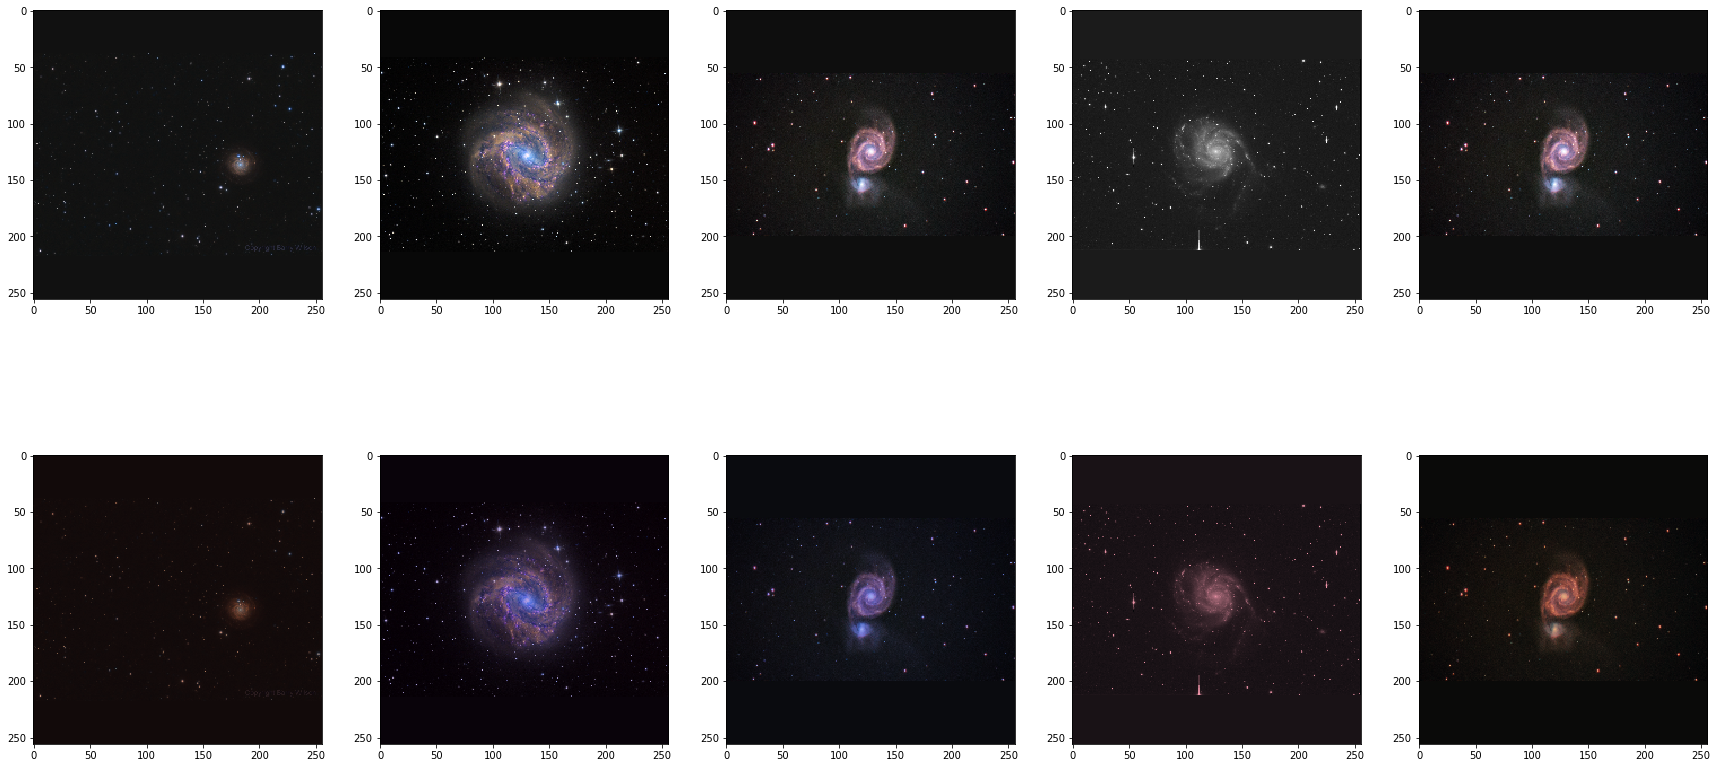

In [93]:
max_step=200
max_it=2000
iteration = 100
train_data,validation_data,test_data = create_datasets()
# image,imageBruitee = next_batch_bruit_voile_2(5,train_data,256,np.float32,
#                                                             [[0,1.-iteration/(max_it+1)],[0,1.-iteration/(max_it+1)],[0,1.-iteration/(max_it+1)]],
#                                                             [iteration//100*100/max_it/2,iteration//100*100/max_it/2],[0,1])

plage_val = [(1.-iteration/(max_it+1))/2,1.-iteration/(max_it+1)]
print("Facteur voile entre %f et %f"%(plage_val[0],plage_val[1]))
image,imageBruitee = next_batch_bruit_voile_2(5,train_data,256,np.float32,
                                                            [plage_val,plage_val,plage_val],
                                                            [0.01,0.01],[0,1])
plt.figure(figsize=(30,15))
it = 1
for statut in range(2):
    for img in range(5):
        plt.subplot(2,5,it)
        plt.imshow(image[img,:,:,:] if statut == 0 else imageBruitee[img,:,:,:])
        it += 1